# **Group Assignment** - Bike Sharing

- `instant`: record index
- `dteday` : date
- `season` : season (1:springer, 2:summer, 3:fall, 4:winter)
- `yr` : year (0: 2011, 1:2012)
- `mnth` : month ( 1 to 12)
- `hr` : hour (0 to 23)
- `holiday` : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- `weekday` : day of the week
- `workingday` : if day is neither weekend nor holiday is 1, otherwise is 0.
+ `weathersit` : 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- `temp` : Normalized temperature in Celsius. The values are divided to 41 (max)
- `atemp`: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- `hum`: Normalized humidity. The values are divided to 100 (max)
- `windspeed`: Normalized wind speed. The values are divided to 67 (max)
- `casual`: count of casual users
- `registered`: count of registered users
- `cnt`: count of total rental bikes including both casual and registered

## PART I: Exploratory Data Analysis

# Import Libraries

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from astral import LocationInfo
from astral.sun import sun
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error
from pycaret.regression import *
from math import sqrt

# Creating decoders

In [4]:
def code_to_season(code):
    if code == 1:
        return "Spring"
    elif code == 2:
        return "Summer"
    elif code == 3:
        return "Fall"
    else:
        return "Winter"

def code_to_weather(code):
    if code == 1:
        return "Clear"
    elif code == 2:
        return "Mist"
    elif code == 3:
        return "Light Snow"
    else:
        return "Heavy Rain"

def calculate_daylight_hours(date):
    try:
        city = LocationInfo("Washington", "USA", "US/Eastern", 38.9072, -77.0369)
        s = sun(city.observer, date=date)
        daylight_hours = (s["sunset"] - s["sunrise"]).seconds / 3600
        return daylight_hours
    except Exception as e:
        return None

def daylight_fill_nulls(data_input):
    bike_data_copy = data_input.copy()
    median_daylight_by_season = bike_data_copy.groupby("season")["daylight_hours"].median()
    bike_data_copy["daylight_hours"] = bike_data_copy.apply(
        lambda row: median_daylight_by_season[row["season"]] if pd.isnull(row["daylight_hours"]) else row["daylight_hours"],
        axis=1
    )
    return  bike_data_copy

def data_fill_empty_by_season_median(data_input, category):
    bike_data_copy = data_input.copy()
    median_by_season = bike_data_copy.groupby('season')[category].median()
    bike_data_copy[category] = bike_data_copy.apply(
        lambda row: median_by_season[row['season']] if row[category] == 0 else row[category],
        axis=1
    )
    return bike_data_copy

In [3]:
data = pd.read_csv("bike-sharing_hourly.csv")
data

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


# Ensuring data quality (correctness, consistency, missing values, outliers...).

In [4]:
bike_data = data.copy()

In [5]:
data_types = bike_data.dtypes
data_types

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [6]:
duplicate_rows = bike_data.duplicated().sum()
duplicate_rows

0

In [9]:
missing_values = bike_data.isnull().sum()
missing_values_df = missing_values.reset_index()
missing_values_df.columns = ['Feature', 'MissingValues']
missing_values_df.to_csv("missing.csv", index=False)
missing_values_df

In [10]:
summary_statistics = bike_data.describe()
summary_statistics

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [11]:
bike_data['dteday'] = pd.to_datetime(bike_data['dteday'])
bike_data['dteday'].dtype

dtype('<M8[ns]')

# Plotting box plot for continuos variables

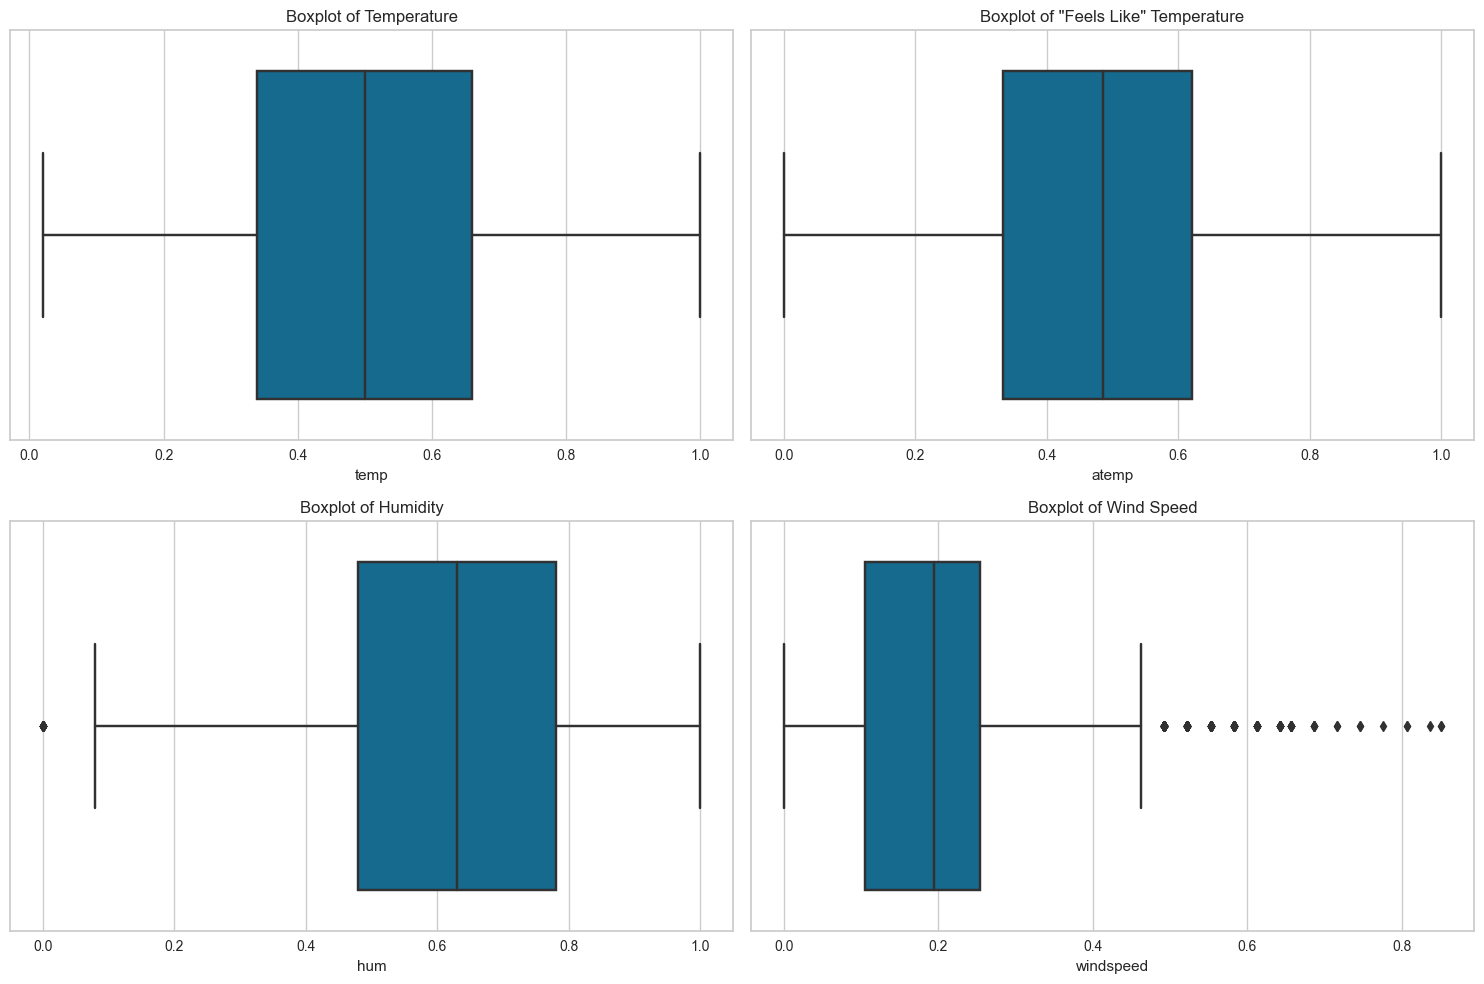

In [12]:
# Plotting boxplots for continuous variables
plt.figure(figsize=(15, 10))

# Subplot for 'temp'
plt.subplot(2, 2, 1)
sns.boxplot(x=bike_data['temp'])
plt.title('Boxplot of Temperature')

# Subplot for 'atemp'
plt.subplot(2, 2, 2)
sns.boxplot(x=bike_data['atemp'])
plt.title('Boxplot of "Feels Like" Temperature')

# Subplot for 'hum'
plt.subplot(2, 2, 3)
sns.boxplot(x=bike_data['hum'])
plt.title('Boxplot of Humidity')

# Subplot for 'windspeed'
plt.subplot(2, 2, 4)
sns.boxplot(x=bike_data['windspeed'])
plt.title('Boxplot of Wind Speed')

plt.tight_layout()
plt.show()

# hum -> Some ceros, maybe an error of the sensor
# windspeed -> Several outliers ; RobustScaler is recommended

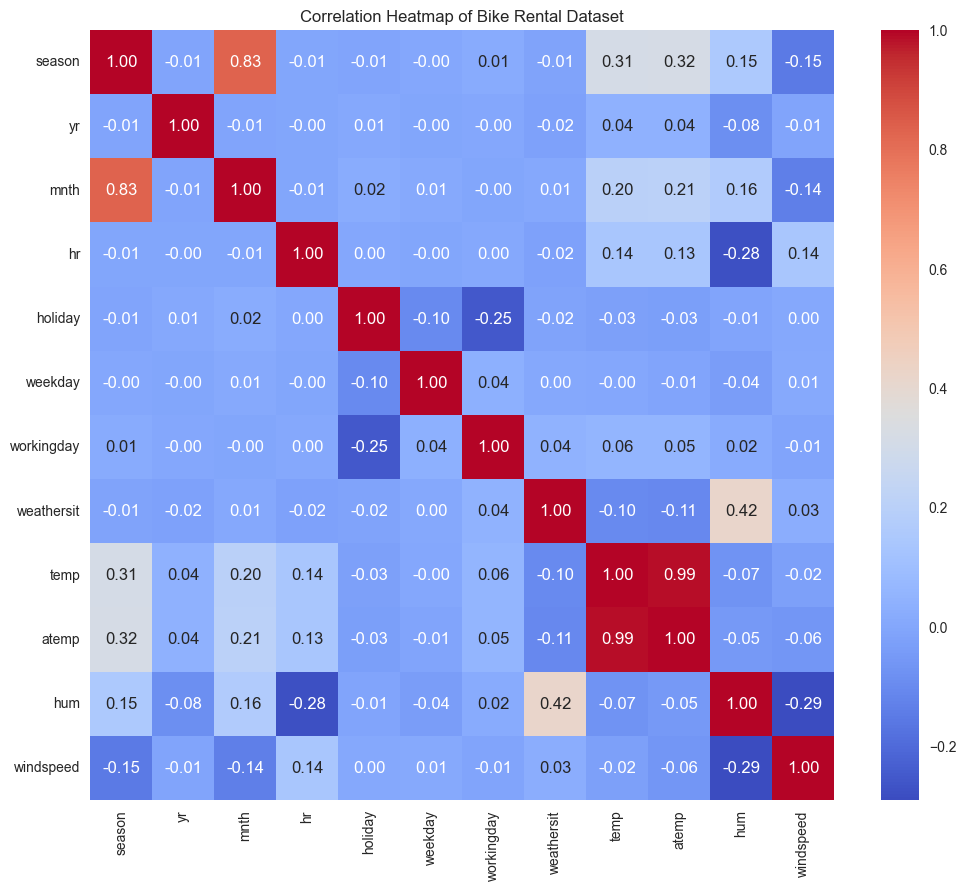

In [13]:
# Plot data without enconding
data_corr = bike_data.drop(columns=["instant","dteday", "casual", "registered", "cnt"])
plt.figure(figsize=(12, 10))
corr_matrix = data_corr.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Bike Rental Dataset')
plt.show()

# High correlations
# season --> mnth
# temp --> atemp

# Adding daylight hours

In [15]:
bike_data['daylight_hours'] = bike_data['dteday'].dt.date.apply(calculate_daylight_hours)
bike_data.isnull().sum()

instant            0
dteday             0
season             0
yr                 0
mnth               0
hr                 0
holiday            0
weekday            0
workingday         0
weathersit         0
temp               0
atemp              0
hum                0
windspeed          0
casual             0
registered         0
cnt                0
daylight_hours    95
dtype: int64

In [16]:
# Calculate the median daylight hours for each season
bike_data = daylight_fill_nulls(bike_data)

In [19]:
bike_data.to_csv("daylight_data.csv", index=False)

In [17]:
bike_data.isnull().sum()

instant           0
dteday            0
season            0
yr                0
mnth              0
hr                0
holiday           0
weekday           0
workingday        0
weathersit        0
temp              0
atemp             0
hum               0
windspeed         0
casual            0
registered        0
cnt               0
daylight_hours    0
dtype: int64

# Run Correlation Again

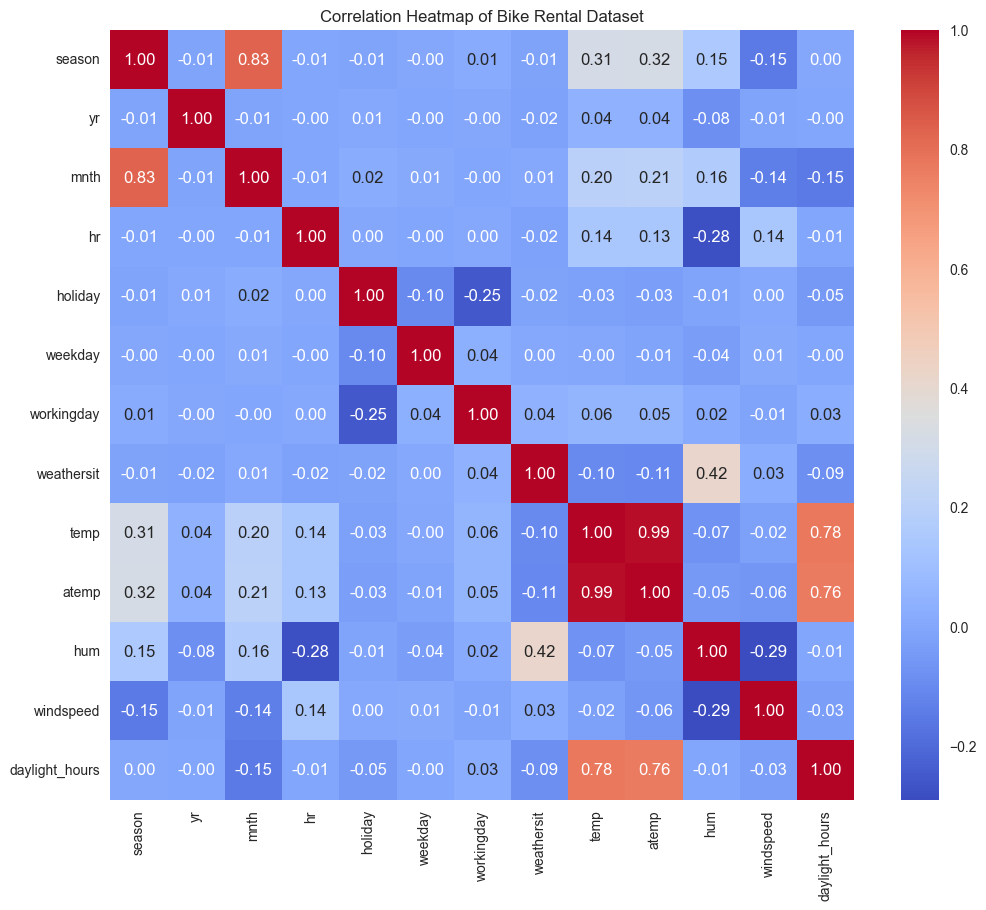

In [18]:
# Plot data without enconding
data_corr = bike_data.drop(columns=["instant","dteday", "casual", "registered", "cnt"])
plt.figure(figsize=(12, 10))
corr_matrix = data_corr.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Bike Rental Dataset')
plt.show()

# High correlations
# season --> mnth
# temp --> atemp

# Giving insights on what seems relevant for prediction and what does not.
## Notes
- No missing values
- hum -> Some ceros, maybe an error of the sensor
- windspeed -> Several outliers 
- High correlations
-- season <--> mnth
-- temp <--> atemp
-- daylight_hours does not have high correlations
## Decisions
-- RobustScaler is recommended because there are outliers
-- Use season instead mnth and year
-- Remove instant, dtedat, year and mnth because data is independent of the date
-- Remove atemp

# Decoding variables

In [ ]:
bike_data.season = bike_data.season.apply(code_to_season)
bike_data.weathersit = bike_data.weathersit.apply(code_to_weather)
bike_data.to_csv("bike_db.csv", index=False)
bike_data


# Plotting clear and meaningful figures.

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=bike_data.index, y=bike_data["cnt"], mode="lines"))
fig.update_layout(title="Bike Rentals Over Time", xaxis_title="Date", yaxis_title="Total Rentals")
fig.show()

fig = px.box(bike_data, x="hr", y="cnt")
fig.update_layout(title="Bike Rentals by Hour of the Day", xaxis_title="Hour of the Day",
                          yaxis_title="Total Rentals")
fig.show()

fig_weather = go.Figure()
fig_weather.add_trace(go.Box(x=bike_data["weathersit"], y=bike_data["cnt"]))
fig_weather.update_layout(title="Bike Rentals by Weather Situation", xaxis_title="Weather Situation", yaxis_title="Total Rentals")
fig_weather.show()

fig_season = go.Figure()
fig_season.add_trace(go.Box(x=bike_data["season"], y=bike_data["cnt"]))
fig_season.update_layout(title="Bike Rentals by Season", xaxis_title="Season", yaxis_title="Total Rentals")
fig_season.show()

In [ ]:
# Grouping the data by 'hr' and 'weathersit' and calculating the sum of 'cnt'
grouped_data = bike_data.groupby(['hr', 'weathersit'])['cnt'].sum().reset_index()
# Pivot the data to get 'weathersit' as columns and 'hr' as rows
pivot_data = grouped_data.pivot(index='hr', columns='weathersit', values='cnt').fillna(0)
# Create a stacked bar chart
fig = px.bar(pivot_data, 
             x=pivot_data.index, 
             y=pivot_data.columns, 
             labels={'value': 'Total Rentals'}, 
             title="Bike Rentals by Hour and Weather Situation")
# Show the plot
fig.show()

In [ ]:
# Grouping the data by 'hr' and 'season' and calculating the sum of 'cnt'
grouped_data = bike_data.groupby(['hr', 'season'])['cnt'].sum().reset_index()

# Pivot the data to get 'season' as columns and 'hr' as rows
pivot_data = grouped_data.pivot(index='hr', columns='season', values='cnt').fillna(0)

# Create a stacked bar chart
fig = px.bar(pivot_data, 
             x=pivot_data.index, 
             y=pivot_data.columns, 
             labels={'value': 'Total Rentals'}, 
             title="Bike Rentals by Hour and Season")

# Show the plot
fig.show()

## PART II: Prediction Model

# Loading data

In [5]:
# Load original dataset to apply transformations and not encode season and weather
bike_data = pd.read_csv("bike-sharing_hourly.csv")
bike_data["dteday"] = pd.to_datetime(bike_data["dteday"])
bike_data["day"] = bike_data["dteday"].dt.day
bike_data["daylight_hours"] = bike_data["dteday"].dt.date.apply(calculate_daylight_hours)
bike_data = daylight_fill_nulls(bike_data)
bike_data = bike_data.drop(columns=["instant", "dteday", "yr", "mnth", "atemp"])
bike_data = data_fill_empty_by_season_median(bike_data, "hum")

categorical_columns = ["season", "hr", "holiday", "weekday", "workingday", "weathersit", "day"]

bike_data

,season,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt,day,daylight_hours
0,1,0,0,6,0,1,0.24,0.81,0.0000,3,13,16,1,9.489167
1,1,1,0,6,0,1,0.22,0.80,0.0000,8,32,40,1,9.489167
2,1,2,0,6,0,1,0.22,0.80,0.0000,5,27,32,1,9.489167
3,1,3,0,6,0,1,0.24,0.75,0.0000,3,10,13,1,9.489167
4,1,4,0,6,0,1,0.24,0.75,0.0000,0,1,1,1,9.489167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,19,0,1,1,2,0.26,0.60,0.1642,11,108,119,31,9.484167
17375,1,20,0,1,1,2,0.26,0.60,0.1642,8,81,89,31,9.484167
17376,1,21,0,1,1,1,0.26,0.60,0.1642,7,83,90,31,9.484167
17377,1,22,0,1,1,1,0.26,0.56,0.1343,13,48,61,31,9.484167


In [9]:
targets = ["cnt", "casual", "registered"]
min_max_values = []

for target in targets:
    min_value = bike_data[target].min()
    max_value = bike_data[target].max()
    min_max_values.append({'Target': target, 'Min': min_value, 'Max': max_value})

min_max_df = pd.DataFrame(min_max_values)
min_max_df.to_csv("target.csv", index=False)
min_max_df

,Target,Min,Max
0,cnt,1,977
1,casual,0,367
2,registered,0,886


# Create a model for cnt

In [13]:
data_model_cnt = bike_data.copy()
data_model_cnt = data_model_cnt.drop(columns=["casual","registered"])

In [14]:
data_dev = data_model_cnt.sample(frac=0.95)
data_prod = data_model_cnt.drop(data_dev.index)
data_dev

,season,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,day,daylight_hours
16100,4,14,0,4,1,1,0.44,0.18,0.4179,182,8,10.262500
12130,2,15,0,5,1,1,0.76,0.62,0.1940,466,25,14.561111
1807,2,0,0,1,1,3,0.34,0.66,0.3881,13,21,12.164444
5830,3,9,1,1,0,3,0.68,0.74,0.1642,152,5,12.865278
10277,1,7,0,5,1,2,0.38,0.40,0.2985,268,9,11.686944
...,...,...,...,...,...,...,...,...,...,...,...,...
10899,2,7,0,3,1,2,0.44,0.62,0.0000,366,4,12.786944
12422,2,19,0,3,1,1,0.56,0.73,0.2985,538,6,14.784722
16899,4,22,0,2,1,1,0.30,0.56,0.2239,106,11,9.478889
1136,1,2,0,0,0,1,0.24,0.41,0.5522,17,20,10.950278


In [15]:
bike_data.loc[data_prod.index].to_csv("prod.csv")

In [16]:
reg_setup = setup(data_dev, target= "cnt", train_size= 0.8, session_id= 123, verbose= False,
                    normalize= True,
                    normalize_method= "robust",
                    n_jobs = -1,
                    use_gpu = False,
                    categorical_features= categorical_columns,
                    max_encoding_ohe = -1, # Always Use OHE 
                    preprocess = True,
                    remove_multicollinearity = True
                   )
best_model = compare_models(sort="MAE", fold=5)
best_model

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,23:10:24
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

In [17]:
cnt_models_df = pull()

In [19]:
cnt_models_df.to_csv("cnt_models.csv", index=False)

In [20]:
model = create_model("catboost")
tuned_model = tune_model(model, optimize = "MAE", fold= 2, n_iter= 2)  

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,23:14:39
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,23:14:58
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 2 folds for each of 2 candidates, totalling 4 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [21]:
final_model = finalize_model(tuned_model)
save_model(final_model, 'cnt_model')
plot_model(final_model, plot='error', save= True)

Transformation Pipeline and Model Successfully Saved


'Prediction Error.png'

In [22]:
pipeline = load_model(model_name="cnt_model")
prediction = predict_model(pipeline, data_prod)
prediction["prediction_label"] = prediction["prediction_label"].round().astype(int).apply(lambda x: max(x, 0))
prediction

Transformation Pipeline and Model Successfully Loaded


,season,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,day,daylight_hours,cnt,prediction_label
22,1,22,0,6,0,2,0.40,0.94,0.2239,1,9.489166,28,43
33,1,10,0,0,0,2,0.36,0.81,0.2239,2,9.500556,53,102
77,1,9,0,2,1,1,0.16,0.64,0.2239,4,9.526667,100,139
105,1,14,0,3,1,1,0.30,0.28,0.1940,5,9.541389,62,87
119,1,5,0,4,1,2,0.14,0.69,0.0896,6,9.556666,4,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17298,1,15,0,5,1,2,0.30,0.49,0.0000,28,9.456667,225,167
17301,1,18,0,5,1,1,0.24,0.60,0.1343,28,9.456667,213,172
17303,1,20,0,5,1,2,0.24,0.65,0.1045,28,9.456667,97,85
17306,1,23,0,5,1,2,0.24,0.65,0.0896,28,9.456667,59,29


In [27]:
# Calculate Errors
actuals = data_prod['cnt'] 
predicted = prediction['prediction_label']  

r2 = r2_score(actuals, predicted)
mae = mean_absolute_error(actuals, predicted)
mse = mean_squared_error(actuals, predicted)
rmse = sqrt(mse)

# Create a DataFrame with the results
metrics_df = pd.DataFrame({
    'Metric': ['R-squared', 'MAE', 'RMSE'],
    'Value': [r2, mae, rmse]
})

metrics_df.to_csv("cnt_metric.csv", index=False)
metrics_df

,Metric,Value
0,R-squared,0.885810
1,MAE,40.584580
2,RMSE,59.929763


# Create model for casual

In [28]:
data_model_casual = bike_data.copy()
data_model_casual = data_model_casual.drop(columns=["cnt","registered"])
data_dev_casual = data_model_casual.loc[data_dev.index]
data_prod_casual = data_model_casual.loc[data_prod.index]

reg_setup_casual = setup(data_dev_casual, target= "casual", train_size= 0.8, session_id= 124, 
                    verbose= False,
                    normalize= True,
                    normalize_method= "robust",
                    n_jobs = -1,
                    use_gpu = False,
                    categorical_features= categorical_columns,
                    max_encoding_ohe = -1, # Always Use OHE 
                    preprocess = True,
                    remove_multicollinearity = True,
                   )
best_model_casual = compare_models(sort="MAE", fold=5)
best_model_casual

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,23:29:21
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

In [30]:
casual_models = pull()
casual_models.to_csv("casual_models.csv", index=False)
casual_models

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,10.3416,277.2636,16.6340,0.8848,0.6886,0.8486,1.392
et,Extra Trees Regressor,10.5384,351.8820,18.7228,0.8541,0.6132,0.6984,1.474
lightgbm,Light Gradient Boosting Machine,10.7503,308.2188,17.5361,0.8720,0.6884,0.8587,0.306
rf,Random Forest Regressor,11.1017,385.6883,19.6210,0.8398,0.6702,0.8280,1.426
xgboost,Extreme Gradient Boosting,11.1716,342.5410,18.4932,0.8577,0.7087,0.8749,0.228
gbr,Gradient Boosting Regressor,14.8906,618.1246,24.8470,0.7429,0.8647,1.3368,0.582
dt,Decision Tree Regressor,15.0889,767.5196,27.6831,0.6810,0.8371,0.9848,0.208
knn,K Neighbors Regressor,15.2713,660.1737,25.6784,0.7255,0.9533,1.4835,0.298
huber,Huber Regressor,19.7020,1228.7827,35.0295,0.4894,1.1108,1.8447,0.470
par,Passive Aggressive Regressor,21.3868,1254.7899,35.3894,0.4787,1.1793,2.2678,0.164


In [32]:
model_casual = create_model("catboost")
tuned_model_casual = tune_model(model_casual, optimize = "MAE", fold= 2, n_iter= 2)  
final_model_casual = finalize_model(tuned_model_casual)
save_model(final_model_casual, 'cnt_model_casual')
plot_model(final_model_casual, plot='error', save= True)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,23:38:31
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,23:39:01
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 2 folds for each of 2 candidates, totalling 4 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Transformation Pipeline and Model Successfully Saved


'Prediction Error.png'

In [33]:
pipeline_casual = load_model(model_name="cnt_model_casual")
prediction_casual = predict_model(pipeline_casual, data_prod_casual)
prediction_casual["prediction_label"] = prediction_casual["prediction_label"].round().astype(int).apply(lambda x: max(x, 0))
prediction_casual

Transformation Pipeline and Model Successfully Loaded


,season,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,day,daylight_hours,casual,prediction_label
22,1,22,0,6,0,2,0.40,0.94,0.2239,1,9.489166,11,4
33,1,10,0,0,0,2,0.36,0.81,0.2239,2,9.500556,7,35
77,1,9,0,2,1,1,0.16,0.64,0.2239,4,9.526667,2,8
105,1,14,0,3,1,1,0.30,0.28,0.1940,5,9.541389,10,11
119,1,5,0,4,1,2,0.14,0.69,0.0896,6,9.556666,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17298,1,15,0,5,1,2,0.30,0.49,0.0000,28,9.456667,74,42
17301,1,18,0,5,1,1,0.24,0.60,0.1343,28,9.456667,16,15
17303,1,20,0,5,1,2,0.24,0.65,0.1045,28,9.456667,14,11
17306,1,23,0,5,1,2,0.24,0.65,0.0896,28,9.456667,5,8


In [34]:
# Calculate Errors
actuals_casual = data_prod_casual['casual'] 
predicted_casual = prediction_casual['prediction_label']  

# Calculate the metrics
r2_casual = r2_score(actuals_casual, predicted_casual)
mae_casual = mean_absolute_error(actuals_casual, predicted_casual)
mse_casual = mean_squared_error(actuals_casual, predicted_casual)
rmse_casual = sqrt(mse_casual)

# Create a DataFrame with the results
metrics_df_casual = pd.DataFrame({
    'Metric': ['R-squared', 'MAE', 'RMSE'],
    'Value': [r2_casual, mae_casual,rmse_casual]
})

metrics_df_casual.to_csv("casual_metrics.csv", index=False)
metrics_df_casual

,Metric,Value
0,R-squared,0.906555
1,MAE,10.041427
2,RMSE,16.477135


# Predicted Registered

In [35]:
data_model_registered = bike_data.copy()
data_model_registered = data_model_registered.drop(columns=["cnt","casual"])
data_dev_registered = data_model_registered.loc[data_dev.index]
data_prod_registered = data_model_registered.loc[data_prod.index]

reg_setup_registered = setup(data_dev_registered, target= "registered", train_size= 0.8,
                    session_id= 125, 
                    verbose= False,
                    normalize= True,
                    normalize_method= "robust",
                    n_jobs = -1,
                    use_gpu = False,
                    categorical_features= categorical_columns,
                    max_encoding_ohe = -1, # Always Use OHE 
                    preprocess = True,
                    remove_multicollinearity = True
                   )
best_model_registered = compare_models(sort="MAE", fold=5)
best_model_registered

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,23:45:38
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

In [36]:
registered_models = pull()
registered_models.to_csv("registered_models.csv", index=False)
registered_models

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,3.668310e+01,2.917654e+03,5.400330e+01,8.731000e-01,0.5975,8.637000e-01,2.108
xgboost,Extreme Gradient Boosting,3.770320e+01,3.161062e+03,5.620160e+01,8.625000e-01,0.6152,8.616000e-01,0.278
lightgbm,Light Gradient Boosting Machine,3.912090e+01,3.331166e+03,5.770840e+01,8.551000e-01,0.5753,7.446000e-01,0.412
rf,Random Forest Regressor,3.983940e+01,3.829096e+03,6.186270e+01,8.335000e-01,0.4819,5.467000e-01,2.808
et,Extra Trees Regressor,4.095040e+01,4.278571e+03,6.539020e+01,8.139000e-01,0.4376,4.424000e-01,2.756
dt,Decision Tree Regressor,5.133680e+01,7.281533e+03,8.532360e+01,6.830000e-01,0.6008,6.241000e-01,0.228
gbr,Gradient Boosting Regressor,5.315910e+01,5.710465e+03,7.556200e+01,7.516000e-01,0.7953,1.375000e+00,0.716
huber,Huber Regressor,6.497480e+01,9.031927e+03,9.502320e+01,6.072000e-01,0.9231,1.894300e+00,0.592
par,Passive Aggressive Regressor,6.710040e+01,9.566123e+03,9.779370e+01,5.840000e-01,0.9331,1.904800e+00,0.148
br,Bayesian Ridge,6.710080e+01,8.724515e+03,9.339620e+01,6.205000e-01,0.9999,2.302100e+00,0.190


In [38]:
model_registered = create_model("catboost")
tuned_model_registered = tune_model(model_registered, optimize = "MAE", fold= 2, n_iter= 2)  
final_model_registered = finalize_model(tuned_model_registered)
save_model(final_model_registered, 'cnt_model_registered')
plot_model(final_model_registered, plot='error', save= True)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,23:51:00
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,23:51:24
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 2 folds for each of 2 candidates, totalling 4 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Transformation Pipeline and Model Successfully Saved


'Prediction Error.png'

In [39]:
pipeline_registered = load_model(model_name="cnt_model_registered")
prediction_registered = predict_model(pipeline_registered, data_prod_registered)
prediction_registered["prediction_label"] = prediction_registered["prediction_label"].round().astype(int).apply(lambda x: max(x, 0))
prediction_registered

Transformation Pipeline and Model Successfully Loaded


,season,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,day,daylight_hours,registered,prediction_label
22,1,22,0,6,0,2,0.40,0.94,0.2239,1,9.489166,17,48
33,1,10,0,0,0,2,0.36,0.81,0.2239,2,9.500556,46,95
77,1,9,0,2,1,1,0.16,0.64,0.2239,4,9.526667,98,135
105,1,14,0,3,1,1,0.30,0.28,0.1940,5,9.541389,52,80
119,1,5,0,4,1,2,0.14,0.69,0.0896,6,9.556666,4,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17298,1,15,0,5,1,2,0.30,0.49,0.0000,28,9.456667,151,131
17301,1,18,0,5,1,1,0.24,0.60,0.1343,28,9.456667,197,141
17303,1,20,0,5,1,2,0.24,0.65,0.1045,28,9.456667,83,78
17306,1,23,0,5,1,2,0.24,0.65,0.0896,28,9.456667,54,26


In [40]:
# Calculate Errors
actuals_registered = data_prod_registered['registered'] 
predicted_registered = prediction_registered['prediction_label']  

r2_registered = r2_score(actuals_registered, predicted_registered)
mae_registered = mean_absolute_error(actuals_registered, predicted_registered)
mse_registered = mean_squared_error(actuals_registered, predicted_registered)
rmse_registered = sqrt(mse_registered)

# Create a DataFrame with the results
metrics_df_registered = pd.DataFrame({
    'Metric': ['R-squared', 'MAE', 'RMSE'],
    'Value': [r2_registered, mae_registered, rmse_registered]
})

metrics_df_registered.to_csv("registered_metrics.csv", index=False)
metrics_df_registered

,Metric,Value
0,R-squared,0.871246
1,MAE,34.492520
2,RMSE,51.831519


# Compound to Actual

In [41]:
# Calculate Errors
actuals_cnt = data_prod['cnt'] 
predicted_compound = prediction_casual['prediction_label']   + prediction_registered['prediction_label']  

r2_compound = r2_score(actuals_cnt, predicted_compound)
print(f"R-squared: {r2_compound}")

mae_compound = mean_absolute_error(actuals_cnt, predicted_compound)
print(f'MAE: {mae_compound}')

mse_compound = mean_squared_error(actuals_cnt, predicted_compound)
rmse_compound = sqrt(mse_compound)
print(f'RMSE: {rmse_compound}')

R-squared: 0.8855727035657344
MAE: 40.95051783659379
RMSE: 59.99211685842858


# Compound to General Model

In [42]:
# Calculate Errors
actuals_cnt = prediction['prediction_label'] 
predicted_compound = prediction_casual['prediction_label']   + prediction_registered['prediction_label']  

r2_compound = r2_score(actuals_cnt, predicted_compound)
print(f"R-squared: {r2_compound}")

mae_compound = mean_absolute_error(actuals_cnt, predicted_compound)
print(f'MAE: {mae_compound}')

mse_compound = mean_squared_error(actuals_cnt, predicted_compound)
rmse_compound = sqrt(mse_compound)
print(f'RMSE: {rmse_compound}')

R-squared: 0.9954735511159262
MAE: 7.756041426927503
RMSE: 10.82298198327784


# Conclusions
- Pycaret is using in 2023 by international community: https://ieeexplore.ieee.org/document/10291605, https://ieeexplore.ieee.org/document/10100285, https://ieeexplore.ieee.org/document/10183591
- polynomial_features and pca does not reduce significant the error
- solar light has a low reduction of error
- We choose R2, MAE and RMSE because was choosen in similar works: https://www.sciencedirect.com/science/article/abs/pii/S0140366419318997, https://link.springer.com/chapter/10.1007/978-3-030-94751-4_25, https://arxiv.org/pdf/2108.00858.pdf 
- Further research about integrate external data

## PART III: Streamlit dashboard

In [ ]:
### This part goes in a separate script ###